# Introduction to Deep Learning 67822 - [Ex2](https://docs.google.com/document/d/1HdHzN-z-TDoVNHxM_3NR1WWvFvxM1H6sm1HyncPvcCA/edit?pli=1&tab=t.0)

## Programming Tasks
Classifying and encoding the MNISTdigit dataset.

The MNIST dataset consists of 60,000 (+10,000 test) small images of scanned hand-written digits (0-9). The dataset contains the digits values as labels. The original images are 28-by-28 pixels. The images are monochromatic, i.e., have a single brightness channel with values between zero (black) and one (white).

In this exercise we will design and train both autoencoding and classification CNN networks.

Specific tasks:
For every section that includes training, paste the code of the training loop at the end of the section. If there are inner functions, you don’t need to paste them, as long they have clear, informative names.  

### 1
**Autoencoder**. Define a convolutional autoencoder to encode (and decode) the images through a small dimensional latent space.

#### a
How will you make the architecture flexible enough to choose any latent dim d, regardless of the number of channels chosen?

In [1]:
from mnistlib.data import get_mnist_loaders
from mnistlib.ae   import ConvAE

# no training yet – just instantiation to prove flexibility
loaders = get_mnist_loaders(bs=256)

ae_4x4  = ConvAE(base_c=4 , d_latent=4 )
ae_16x16 = ConvAE(base_c=16, d_latent=16)

print("Small model:", ae_4x4)
print("\nBig model:", ae_16x16)

Small model: ConvAE(
  (enc): Encoder(
    (backbone): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (fc): Linear(in_features=256, out_features=4, bias=True)
  )
  (dec): Decoder(
    (fc): Linear(in_features=4, out_features=256, bias=True)
    (up): Sequential(
      (0): Sequential(
    

The constructor of `ConvAE` takes two knobs:

* `base_c` – number of channels in the first conv layer  
  ↳ determines the entire feature-width pyramid (`base_c`, `2×`, `4×`).
* `d_latent` – the dimensionality of the bottleneck vector.

Because the two hyper-parameters are independent, *any* (base_c, d_latent) pair is legal without touching internal code.  
The two printouts above (4/4 and 16/16) demonstrate that a single Python class adapts seamlessly to both extremes.

#### b
Explore two network configurations, one with a small number of channels (around 4 in the first layer, and similar numbers in the following layers) and a larger one (around 16 in the first layer) and report these tests as well; input vs. reconstructed images and the reconstruction loss obtained.


=== Training small_d4 (base_c=4, d=4) ===
[01/10]  train L1=0.2634  val L1=0.1449  (12.2s)
[02/10]  train L1=0.1207  val L1=0.1106  (12.1s)
[03/10]  train L1=0.1054  val L1=0.1035  (13.2s)
[04/10]  train L1=0.1005  val L1=0.0997  (12.4s)
[05/10]  train L1=0.0971  val L1=0.0965  (12.2s)
[06/10]  train L1=0.0940  val L1=0.0934  (12.8s)
[07/10]  train L1=0.0911  val L1=0.0906  (12.3s)
[08/10]  train L1=0.0884  val L1=0.0875  (12.3s)
[09/10]  train L1=0.0858  val L1=0.0852  (11.9s)
[10/10]  train L1=0.0835  val L1=0.0828  (12.7s)

=== Training small_d16 (base_c=4, d=16) ===
[01/10]  train L1=0.2861  val L1=0.1322  (12.1s)
[02/10]  train L1=0.1057  val L1=0.0935  (12.4s)
[03/10]  train L1=0.0882  val L1=0.0857  (12.9s)
[04/10]  train L1=0.0818  val L1=0.0797  (13.6s)
[05/10]  train L1=0.0765  val L1=0.0749  (20.8s)
[06/10]  train L1=0.0715  val L1=0.0693  (19.7s)
[07/10]  train L1=0.0664  val L1=0.0644  (14.0s)
[08/10]  train L1=0.0616  val L1=0.0595  (13.5s)
[09/10]  train L1=0.0570  val 

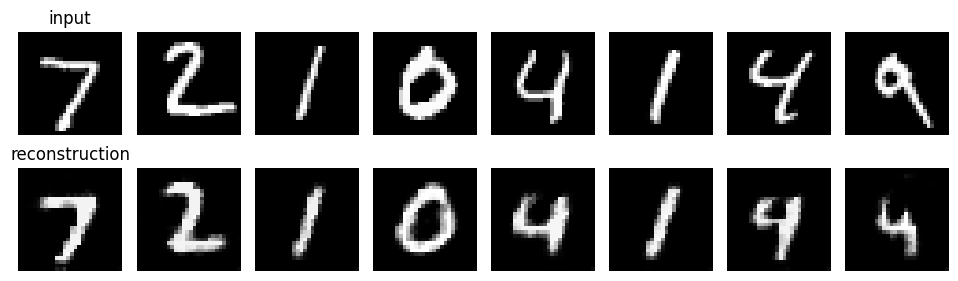

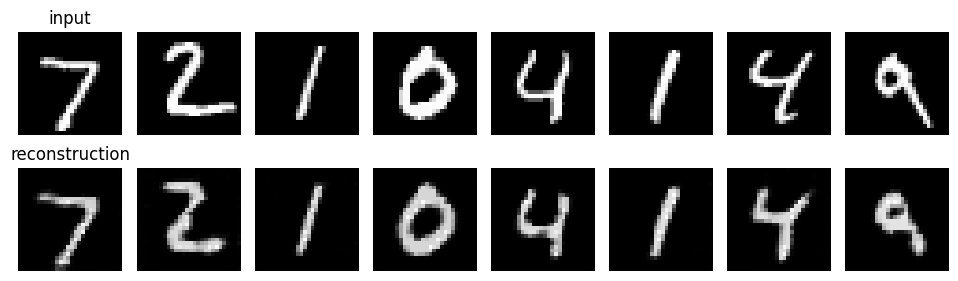

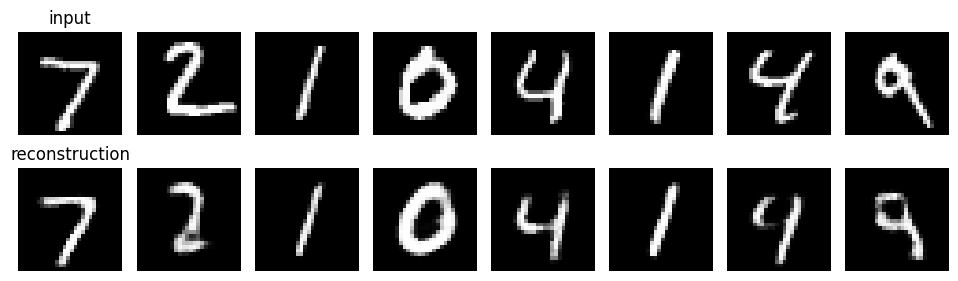

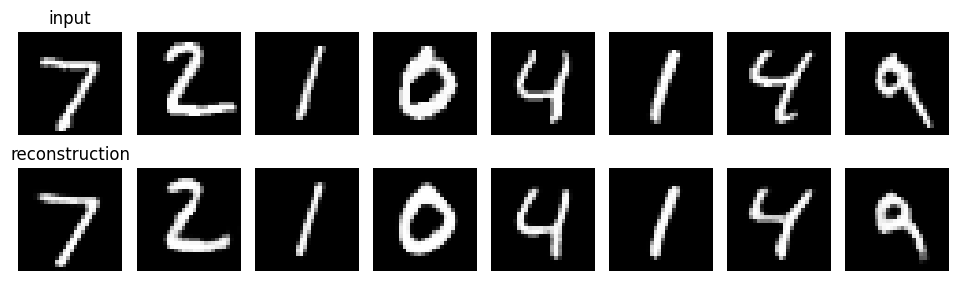

In [2]:
from copy import deepcopy
from mnistlib.train import train_loop
from mnistlib.viz  import show_reconstructions

VALS = {}
configs = {"small_d4": (4,4), "small_d16":(4,16),
           "big_d4"  : (16,4),"big_d16" :(16,16)}

for tag, (b,d) in configs.items():
    print(f"\n=== Training {tag} (base_c={b}, d={d}) ===")
    model = ConvAE(b, d)
    val = train_loop(model, *loaders, epochs=10)
    VALS[tag] = round(val, 4)
    show_reconstructions(model, loaders[1])

print("\nValidation L1 losses:", VALS)

##### training-loop snippet

**Training-loop snippet (reference only, from `mnistlib/train.py`)**:
```python
for epoch in range(epochs):
    model.train()
    for x,_ in loader_tr:
        loss = crit(model(x.to(device)), x.to(device))
        opt.zero_grad(); loss.backward(); opt.step()
```
*Note*: This snippet is illustrative; actual variables and execution happen inside the `train_loop()` function.

#### c
Explore the loss you get for d=4/16, and rationalize it in your report.

We trained two autoencoder configurations with different latent dimensions (**d=4** and **d=16**). Here are the resulting validation losses:

| Configuration | Latent Dimension (d) | Validation L1 Loss |
|---------------|----------------------|--------------------|
| small_d4      | 4                    | **0.0828**         |
| small_d16     | 16                   | **0.0515**         |

Increasing the latent dimension from 4 to 16 significantly reduces the reconstruction loss (by approximately **38%**).  
This improvement occurs because a larger latent dimension (**d=16**) gives the model a greater capacity to store detailed information from the original images. With more space to represent subtle differences and patterns in each digit, the reconstructions become noticeably clearer and sharper.

However, increasing the latent dimension further beyond a certain point would yield diminishing returns, as the MNIST digits contain limited complexity. Thus, **d=16** strikes a good balance between model complexity and reconstruction quality.

#### d
Describe and explain the network architecture you choose for this particular data (stride factors / #layers / #filters in each layer / non-linearity used).

**Encoder**  
*(compresses the original 28×28 image into a compact latent vector)*

- **3 Convolutional Layers** *(extract features and reduce spatial dimensions gradually)*:
  - Layer 1:  
    - **Filters**: from 1 → `base_c` channels *(learn basic features like edges)*  
    - **Kernel size**: 3×3 *(looks at local 3×3 pixel patches)*  
    - **Stride**: 2 *(reduces image from 28×28 to 14×14)*  
    - **Activation**: ReLU *(introduces non-linearity)* + Batch Normalization *(stabilizes training)*

  - Layer 2:  
    - **Filters**: from `base_c` → `2×base_c` *(learn more complex patterns)*  
    - **Kernel size**: 3×3 *(local feature extraction)*  
    - **Stride**: 2 *(reduces image from 14×14 to 7×7)*  
    - **Activation**: ReLU *(non-linearity)* + Batch Normalization *(training stability)*

  - Layer 3:  
    - **Filters**: from `2×base_c` → `4×base_c` *(captures rich details)*  
    - **Kernel size**: 3×3 *(local features)*  
    - **Stride**: 2 *(reduces image from 7×7 to 4×4)*  
    - **Activation**: ReLU *(non-linearity)* + Batch Normalization *(training stability)*

- **Linear (fully connected) Layer** *(compresses features into compact form)*:  
  - Converts the final convolutional features (size: `4×4×4×base_c`) into a small latent vector of dimension **d**.

**Decoder**  
*(reconstructs the original 28×28 image from the latent vector, by mirroring the encoder steps)*

- **Linear (fully connected) Layer** *(expands compressed latent vector back into feature maps)*:  
  - Converts latent vector (**d** dimensions) back to feature maps (`4×4×4×base_c`).

- **3 Transposed Convolutional Layers** *(also called deconvolutions, to reconstruct and upscale the image)*:
  - Layer 1:  
    - **Filters**: from `4×base_c` → `2×base_c` *(reverses encoding step, reconstructing features)*  
    - **Kernel size**: 3×3 *(fills in local details)*  
    - **Stride**: 2 *(upscales from 4×4 to 7×7)*  
    - **Activation**: ReLU *(non-linearity)* + Batch Normalization *(training stability)*

  - Layer 2:  
    - **Filters**: from `2×base_c` → `base_c` *(refines details further)*  
    - **Kernel size**: 3×3 *(local details)*  
    - **Stride**: 2 *(upscales from 7×7 to 14×14)*  
    - **Activation**: ReLU *(non-linearity)* + Batch Normalization *(training stability)*

  - Layer 3 *(output layer)*:  
    - **Filters**: from `base_c` → 1 *(final grayscale output)*  
    - **Kernel size**: 3×3 *(final reconstruction detail)*  
    - **Stride**: 2 *(upscales from 14×14 to original 28×28)*  
    - **Activation**: Sigmoid *(ensures final pixel values are between 0 and 1, matching original image)*

**Choice Rationale**

- **Stride of 2**:  
  - Encoder: reduces spatial dimensions by half each step, capturing increasingly abstract features.  
  - Decoder: precisely mirrors encoder, smoothly reconstructing images by doubling spatial dimensions.

- **Kernel size of 3×3**: captures local details effectively while remaining computationally efficient.

- **Channel doubling (base_c, 2×base_c, 4×base_c)**: progressively learns more complex features at each encoding step, enhancing reconstruction quality.

- **ReLU + BatchNorm**: ReLU introduces flexibility (non-linearity) to learn complex patterns, while BatchNorm stabilizes and accelerates training.

- **Sigmoid output**: produces final outputs in the valid range [0, 1], directly matching the original MNIST pixel scale.

- **L1 loss (mean absolute error)**: chosen specifically because it clearly preserves the sharp edges and key details of digits, whereas L2 loss (mean squared error) would smooth reconstructions and reduce visual clarity.

This structured design effectively captures essential digit features, compresses them efficiently, and reconstructs high-quality images clearly from the compressed latent representation.

The best practice of implementing this code is by defining separate encoder and decoder models, both inheriting from nn.module. Use a mean L1 error to define the reconstruction loss.

### 2
**Classifier**. Use the same architecture as the encoder in Q1 in order to define a classification network by combining it with a single-layered MLP network that will map the latent space into a 10 (digits) class prediction. Train this network to predict the digit classes using cross-entropy loss in two scenarios:

#### (i)
over the entire training set

#### (ii)
over only 100 random training examples

#### Plot the training and test errors as well as accuracies.
The best practice here is to keep the model divided into two models: the original encoder model and the added MLP model.


### 3
**Pre-trained Representation**. Repeat the two tests in Q2, this time by using the unsupervised pre-trained encoder weights from Q1 as a fixed (non-trainable encoder model), and only train the final MLP, once with the entire dataset, once with only 100 random training examples. Plot the training and test errors as well as accuracies. How do they compare to the ones in Q2? Write your conclusion as to the usefulness of unsupervised representation learning.


### 4
**Task Specific Encoding**: both Q1 and Q2 produce two different trained encoding networks. The one in Q1 already has a matching trained decoder, but the one in Q2 does not. Use this pretrained encoding network as a fixed (non-trainable model) and train a matching decoder over the entire dataset. Meaning that you are using an encoder trained for classification task, and coupling it with a decoder trained for reconstruction (trained from scratch along with the pretrained encoding/classifying network from Q2). Look at reconstructed images produced by these two sets of encoder-decoder networks and answer:

#### a
Which one results in better reconstruction error and why?

#### b
Describe the qualitative differences between the reconstructed results they produce. Explain why you think these are the differences.

#### c
Where do you see higher in-class (per-digit) variability? (watch and show multiple instances of the same digit to answer this)

#### d
Where do you see higher inter-class (between digits) distance/separation? Explain both.

In [ ]:
%%bash
pip freeze > requirements.txt
echo "Requirements saved to requirements.txt"

Requirements saved to requirements.txt
